In [2]:
import pandas as pd
import numpy as np
from methods import data_handler
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product

/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Bad key "text.kerning_factor" on line 4 in
/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Metrics calculation

In [52]:
DATA_PATH = "data2/data_tu-helpfulness-of-xai_2022-06-29_10-48.xlsx"
DATA_PREPARED_PATH = f"{DATA_PATH.split('.')[0]}_PREPARED.{DATA_PATH.split('.')[1]}"
df = pd.read_excel(DATA_PATH)
df_merged = pd.read_excel(DATA_PREPARED_PATH)

In [53]:
df_quest_meta = pd.read_excel("data2/question_meta_data.xlsx")

## Metrics on all images (fixed + random)

### Overall ability to guess model is correct if actually correct

In [54]:
# explicit calculation of ratios as verification for grouped calulations further below
num_guessed_correct_if_correct = df_merged[(df_merged["is_pred_correct"] == True) & (df_merged["response"] == True)].shape[0]
num_correct_overall = df_merged[df_merged["is_pred_correct"] == True].shape[0]

In [55]:
num_guessed_correct_if_correct / num_correct_overall

0.6268382352941176

### Overall ability to guess model is wrong if actually wrong

In [56]:
num_guessed_wrong_if_wrong = df_merged[(df_merged["is_pred_correct"] == False) & (df_merged["response"] == False)].shape[0]
num_wrong_overall = df_merged[df_merged["is_pred_correct"] == False].shape[0]

In [57]:
num_guessed_wrong_if_wrong / num_wrong_overall

0.5471813725490197

### Ability for each XAI-method to guess model is correct/wrong if actually correct/wrong & general accuray

In [150]:
def accuracy_per_groupby(df_merged, group_by=["method"]):
    # ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    ser_denominators = df_merged.groupby(by=group_by)["response"].count()
    ser_numerators = df_merged.groupby(by= group_by + ["is_pred_correct"])["response"].value_counts().to_frame("ratio").reset_index()
    ser_numerators = ser_numerators[ser_numerators["is_pred_correct"] == ser_numerators["response"]].groupby(group_by).sum()["ratio"]
    df_accuracies = (ser_numerators / ser_denominators).to_frame("accuracy")
    return df_accuracies

In [151]:
df_accuracy = accuracy_per_groupby(df_merged)

In [152]:
df_accuracy

,accuracy
method,
ConfidenceScores,0.698529
IntegratedGradients,0.533088
LIME,0.545956
LRP,0.584559
SHAP,0.558824
gradCAM,0.601103


In [123]:
# accuracy overall
df_accuracy.mean()

0.5870098039215687

In [59]:
def create_individual_ratios(df_merged):
    # CORRECT = TP / TP + FN; WRONG = TN / TN + FP
    df_ratios_per_method = df_merged.groupby(by=["method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [60]:
df_ratios_per_method = create_individual_ratios(df_merged)

In [61]:
df_ratios_per_method

,method,is_pred_correct,response,ratio
0,ConfidenceScores,False,False,0.647059
1,ConfidenceScores,True,True,0.750000
2,IntegratedGradients,False,False,0.511029
3,IntegratedGradients,True,True,0.555147
4,LIME,False,False,0.503676
5,LIME,True,True,0.588235
6,LRP,False,False,0.426471
7,LRP,True,True,0.742647
8,SHAP,False,False,0.775735
9,SHAP,True,True,0.341912


In [62]:
def plot_ratios(df_ratios_per_method, title_addition=""):        
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"], c="orange", label="Guessed Correct when Model Correct")
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"], c="purple", label="Guessed Wrong when Model Wrong")
    ax.plot(df_ratios_per_method["method"], [0.5] * len(df_ratios_per_method), color="red", linestyle='dashed', label="baseline")
    ax.set_title(f"{title_addition} Performance Ratios for chosen XAI-Methods ({len(df)} participants considered)", size=15)
    ax.set_xlabel("XAI-Method", size=13)
    ax.set_ylabel("Ratio", size=13)
    for i, txt in enumerate(df_ratios_per_method["ratio"].round(2)):
        ax.annotate(txt, (list(df_ratios_per_method["method"])[i], list(df_ratios_per_method["ratio"])[i]))
    ax.legend(loc="best", edgecolor="black")

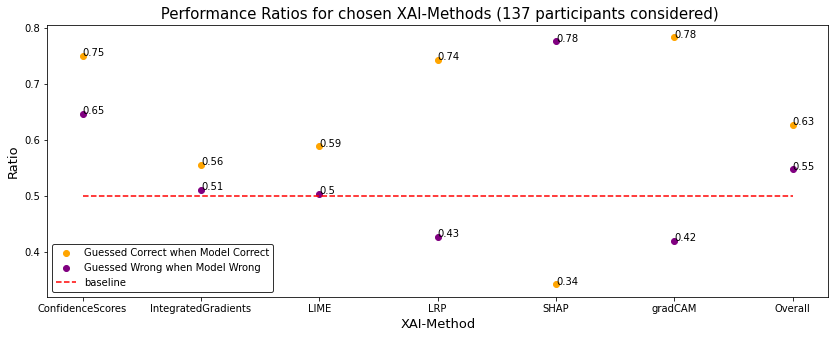

In [63]:
plot_ratios(df_ratios_per_method)

## Metrics only on fixed images

In [64]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]

In [65]:
df_merged_fixed = df_merged[df_merged["img_idx"].isin(fixed_img_idxs)]

In [66]:
df_ratios_per_method_fixed = create_individual_ratios(df_merged_fixed)

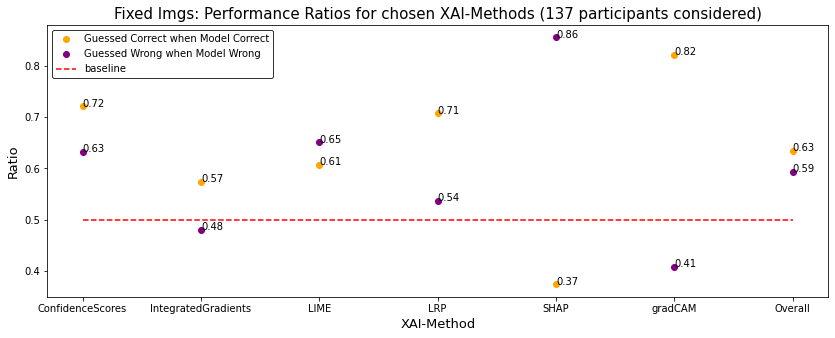

In [67]:
plot_ratios(df_ratios_per_method_fixed, "Fixed Imgs:")

## Convergence of ratio values as more participant results are taken into account

In [68]:
def create_individual_ratios_per_participant(df_merged):
    # df_schema needed to get all TP,TN,FP,FN i.e. where value_counts() would evaluate nothing because not existent (0)
    df_schema = pd.DataFrame(list(product(df_merged["case"].drop_duplicates(), df_merged["method"].drop_duplicates(), df_merged["is_pred_correct"].drop_duplicates(), df_merged["response"].drop_duplicates()))).groupby([0, 1, 2, 3]).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=['case', 'method', 'is_pred_correct', 'response']
    df_ratios_per_method_and_part = df_merged.groupby(by=["case", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method_and_part = df_schema.merge(right=df_ratios_per_method_and_part, on=["case", "method", "is_pred_correct", "response"], how="left")
    df_ratios_per_method_and_part = df_ratios_per_method_and_part.fillna(0)
    # only filter for TP and TP (just for now, might get modified)
    df_ratios_per_method_and_part = df_ratios_per_method_and_part[df_ratios_per_method_and_part["is_pred_correct"] == df_ratios_per_method_and_part["response"]].reset_index(drop=True)
    return df_ratios_per_method_and_part.groupby(by=["method", "is_pred_correct"]).expanding().mean()#.reset_index(level=2, drop=True)
    #return df_ratios_per_method_and_part
    
    # df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    # df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    # df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]

In [69]:
df_ratios_convergence = create_individual_ratios_per_participant(df_merged)
df_ratios_convergence

case  response     ratio
method           is_pred_correct                                      
ConfidenceScores False           0      579.000000       0.0  1.000000
                                 12     580.000000       0.0  0.500000
                                 24     582.333333       0.0  0.500000
                                 36     584.000000       0.0  0.500000
                                 48     588.200000       0.0  0.600000
...                                            ...       ...       ...
gradCAM          True            1583  1123.303030       1.0  0.791667
                                 1595  1127.293233       1.0  0.789474
                                 1607  1131.238806       1.0  0.783582
                                 1619  1135.140741       1.0  0.785185
                                 1631  1139.000000       1.0  0.783088

[1632 rows x 3 columns]

In [70]:
def plot_ratio_convergence(df_ratios_convergence):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel("Ratio", size=13)
    ax.set_title("Convergence of Ratios as Ratios are calculated over increasing Numbers of Participants", size=15)
    for method in df_ratios_convergence.index.get_level_values(0).drop_duplicates():
        for outcome in df_ratios_convergence.index.get_level_values(1).drop_duplicates():
            ax.plot(list(range(len(df_ratios_convergence.loc[method, outcome]))), df_ratios_convergence.loc[method, outcome]["ratio"], label=f"{method}, {outcome}")
            # print(df_ratios_convergence.loc[method, outcome]["ratio"].iloc[-1])
    ax.legend(loc="lower center", edgecolor="black")

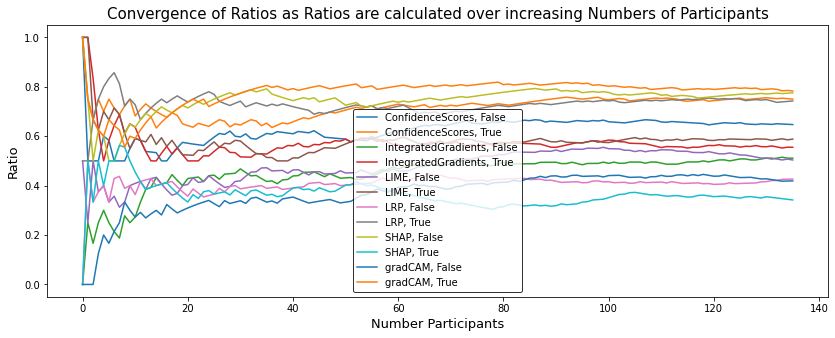

In [71]:
plot_ratio_convergence(df_ratios_convergence, )

## Metrics per questionnaire form (detect outlier questionaires)

In [72]:
def create_individual_ratios_per_questionnaire(df_merged):
    df_ratios_per_method = df_merged.groupby(by=["QUESTNNR", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    #df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    #df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [73]:
df_ratios_qustn = create_individual_ratios_per_questionnaire(df_merged)

In [74]:
def plot_boxplot_over_qnrs_per_method(df_ratios_qustn):
    fig, ax = plt.subplots(6, 1, figsize=(20, 6*5))
    for meth_idx, meth in enumerate(df_ratios_qustn.index.levels[0]):
        for out_idx, out in enumerate(df_ratios_qustn.index.levels[1]):
            ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
            ax[meth_idx].set_title(meth)
            ax[meth_idx].legend()

Text(0, 0.5, 'Test')

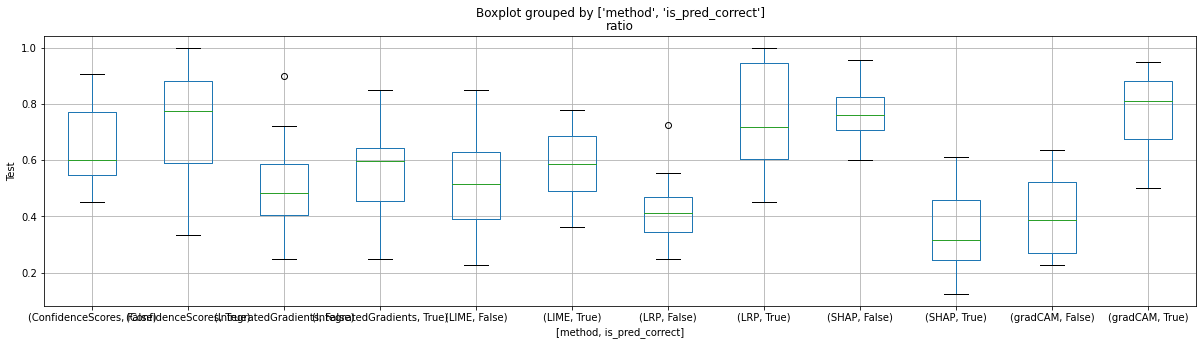

In [75]:
ax = df_ratios_qustn.boxplot(by=["method", "is_pred_correct"], column="ratio", figsize=(20, 5))
ax.set_ylabel("Test")

In [76]:
# each boxplot was genereated on the basis of 12 ratio values origin from the 12 questionnaires.
# interpretation: per method an output the ratios vary quite a lot over the 12 questionnaires.
# for a more drilled down view on each single ratio per method and questionaire form see comprehensive view below

In [77]:
def plot_ratios_per_questionnaire(df_ratios_qustn):
    df_ratios_qustn = df_ratios_qustn.set_index(["method", "is_pred_correct"])
    fig, ax = plt.subplots(6, 1, figsize=(20, 6*5))
    for meth_idx, meth in enumerate(df_ratios_qustn.index.levels[0]):
        for out_idx, out in enumerate(df_ratios_qustn.index.levels[1]):
            ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
            ax[meth_idx].set_title(meth)
            ax[meth_idx].legend()

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_11822/3480523480.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_11822/3480523480.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_11822/3480523480.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_11822/3480523480.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax[meth_idx].scatter(df_r

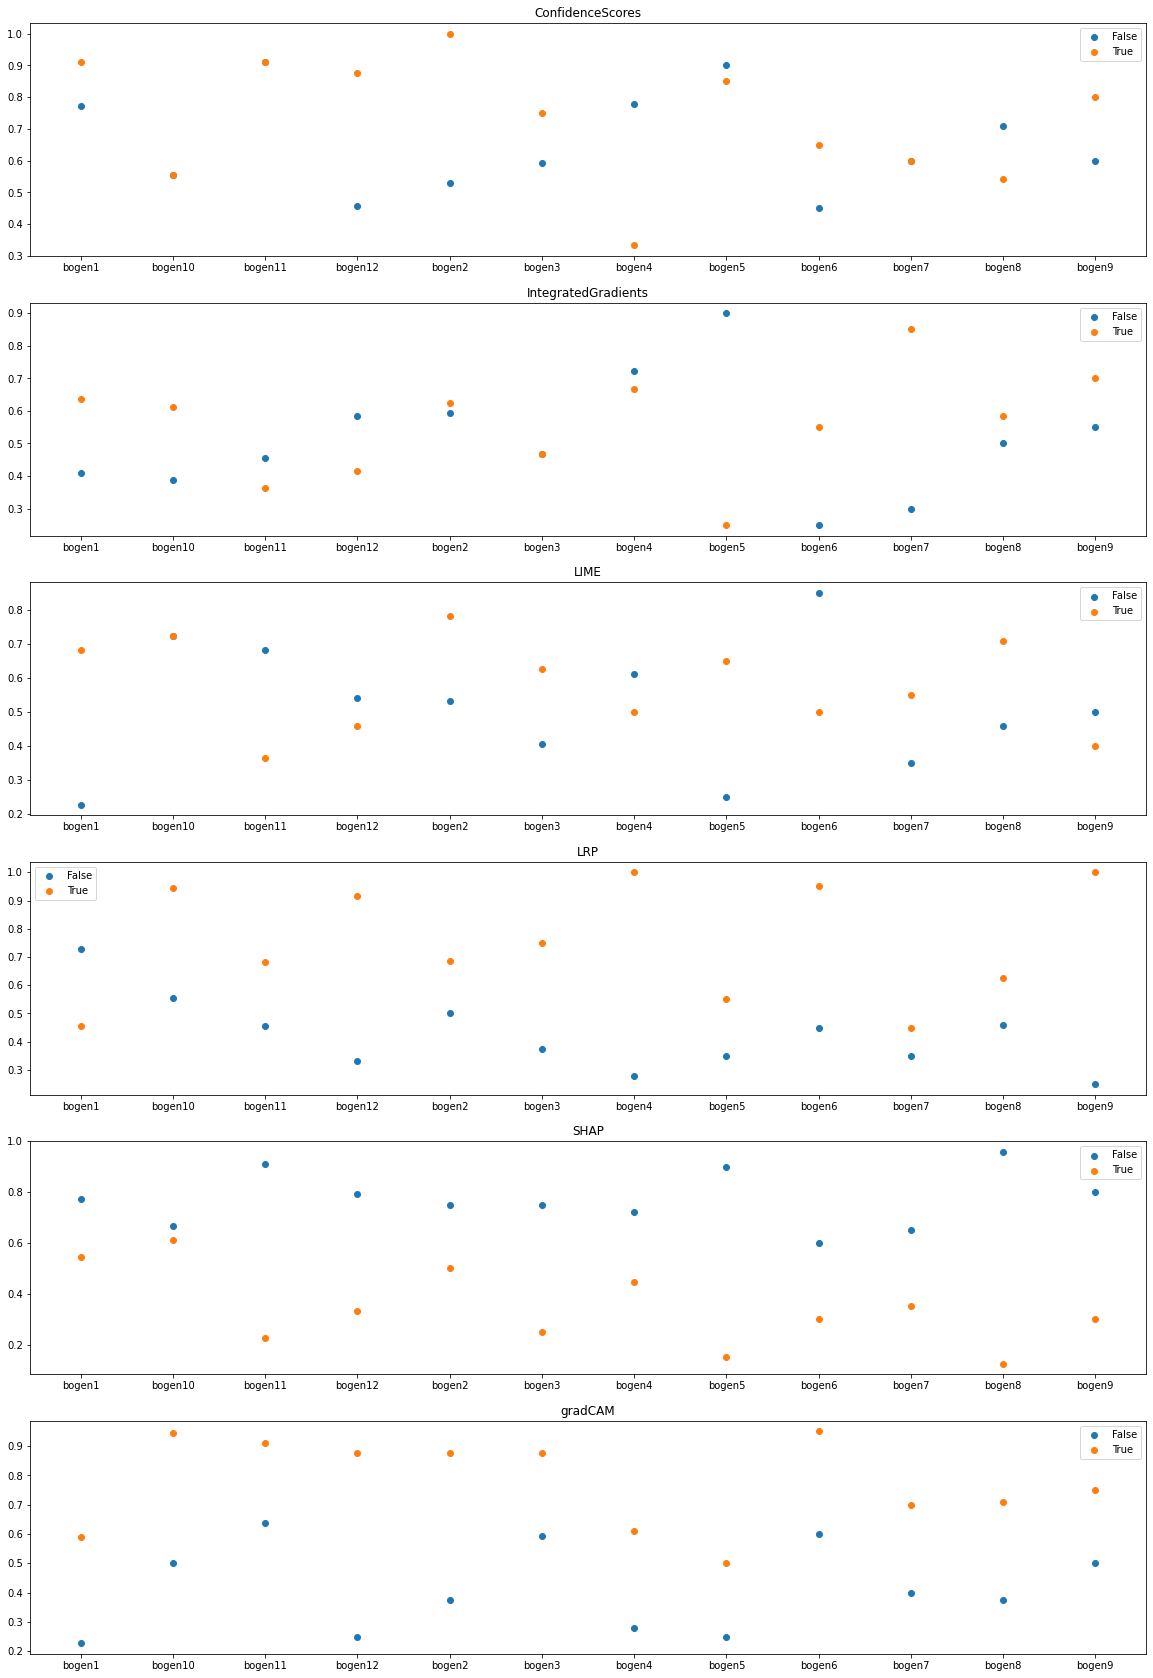

In [80]:
plot_ratios_per_questionnaire(df_ratios_qustn)

## Metrics (here only accuracy) for different education levels

In [153]:
df_accuracy_group_method = accuracy_per_groupby(df_merged, group_by=["Education", "method"])

In [154]:
df_accuracy_group_method

accuracy
Education                         method                       
Graduate                          ConfidenceScores     0.659091
                                  IntegratedGradients  0.573864
                                  LIME                 0.482955
                                  LRP                  0.619318
                                  SHAP                 0.585227
                                  gradCAM              0.596591
Highschool                        ConfidenceScores     0.725000
                                  IntegratedGradients  0.500000
                                  LIME                 0.600000
                                  LRP                  0.462500
                                  SHAP                 0.600000
                                  gradCAM              0.612500
Other                             ConfidenceScores     1.000000
                                  IntegratedGradients  1.000000
                                  LIME                 0.500000
                                  LRP                  0.500000
                                  SHAP                 0.750000
                                  gradCAM              0.750000
PhD                               ConfidenceScores     0.632353
                                  IntegratedGradients  0.411765
                                  LIME                 0.573529
                                  LRP                  0.573529
                                  SHAP                 0.544118
                                  gradCAM              0.705882
Postgraduate                      ConfidenceScores     0.721154
                                  IntegratedGradients  0.576923
                                  LIME                 0.557692
                                  LRP                  0.663462
                                  SHAP                 0.519231
                                  gradCAM              0.586538
Trade School (ger.: "Ausbildung") ConfidenceScores     0.875000
                                  IntegratedGradients  0.437500
                                  LIME                 0.687500
                                  LRP                  0.500000
                                  SHAP                 0.562500
                                  gradCAM              0.500000
Undergraduate                     ConfidenceScores     0.729167
                                  IntegratedGradients  0.520833
                                  LIME                 0.562500
                                  LRP                  0.562500
                                  SHAP                 0.520833
                                  gradCAM              0.552083

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_11822/2980017738.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


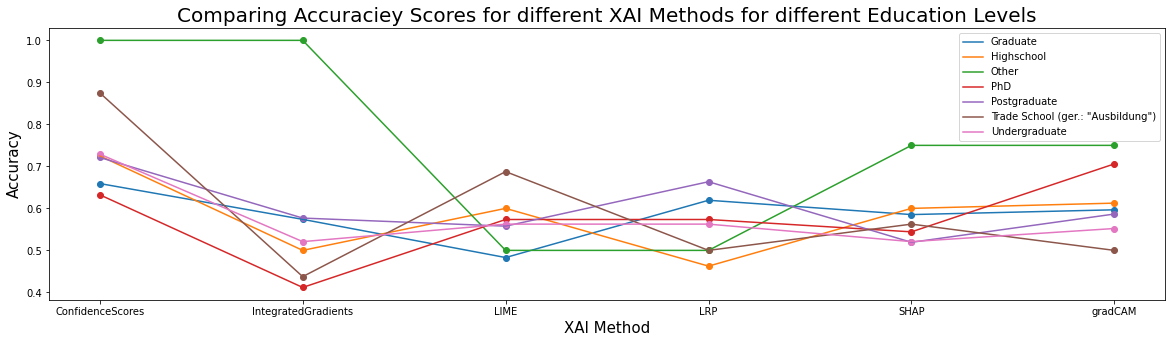

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for education in df_accuracy_group_method.index.levels[0]:
    ax.plot(df_accuracy_group_method.loc[education].index, list(df_accuracy_group_method.loc[education]["accuracy"]), label=education)
    ax.scatter(df_accuracy_group_method.loc[education].index, list(df_accuracy_group_method.loc[education]["accuracy"]))
ax.legend()
ax.set_xlabel("XAI Method", size=15)
ax.set_ylabel("Accuracy", size=15)
ax.set_title("Comparing Accuraciey Scores for different XAI Methods for different Education Levels", size=20)
fig.show()
        